#  **SCC0270 - Redes Neurais e Aprendizado Profundo**

## **Trabalho 1**

* Dataset: MedPix 2.0 with DR-Minerva and Knowledge Graph
* Multimodalidade: texto e imagem
* Problema: classificação multi-classe

* Arxiv: https://arxiv.org/html/2407.02994v1#S3
* Github: https://github.com/CHILab1/MedPix-2.0

## Introdução 

O objetivo do Trabalho 01 é construir um algoritmo de classificação binária para classificar as imagens da base MedPix-2.0, de acordo com as duas labels disponíveis `CP` e `MRI`. 

Usaremos as métricas apresentadas pelos autores no artigo no ArXiv como fator comparativo para nossos modelos nesta primeira tarefa de classificação de modalidade. 

De início, utilizaremos descritores de imagens e texturas para extrair as características da imagem para construir os algoritmos de classificação.


## Resultados dos Autores

Conforme documentado no artigo, para a tareda de classificação da Modalidade da Imagem, os autores obtiveram os seguintes valores de acurácias, com os seguintes modelos:

* RN50x16 and CLIP encoder: `58% accuracy` 
* BioBERT: `88% accuracy`

---

In [45]:
# Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt

import warnings; warnings.filterwarnings("ignore")
import requests
import json
from PIL import Image
from io import BytesIO
import os
import cv2
import mahotas as mt 
from skimage import io  
import numpy as np

In [20]:
# # Importar o MyDrive
# drive.mount('/content/drive')

## 0.0 - Informações sobre os dados 

Localmente, os dados estão presentes na pasta `MedPix-2.0`. Os dados com o split, estão na pasta `MedPix-2.0/splitted_dataset`.

Os dados foram divididos em dois tipos de Documentos JSON:

1. `Description Document`: dados com informações referentes apenas as imagens. 
2. `Case-Topic Document`: dados com informações relacionadas ao caso clínico. 

Existe uma relação do tipo **uma-para-muitos** entre um dado do tipo Descrition e outro do tipo Case-Topic.

O arquivo `uid_list.json` apresenta os UIds que foram utilizados na divisão das bases `Case_topic.json` e `Descriptions.json` nas bases de `train`, `train_1`, `train_2`, `dev` e `test`.

Portanto, utilizaremos as divisões realizadas pelos autores para o treinamento dos algoritmos.

## 0.1 Importando as descrições

In [21]:
def get_descriptions(url:str):

    # Importanto as descrições
    response = requests.get(url)
    # Separando por linha
    descricoes = response.text.splitlines() 
    return descricoes

In [22]:
GITHUB_URL = "https://raw.githubusercontent.com/CHILab1/MedPix-2.0/refs/heads/main/MedPix-2-0/splitted_dataset/descriptions_dev.jsonl"

In [23]:
# Exemplo: descrição da posição 0
get_descriptions(GITHUB_URL)[0]

'{"Type":"CT","U_id":"MPX1009","image":"MPX1009_synpic46283","Description":{"ACR Codes":"8.-1","Age":"73","Caption":"The prostate is enlarged with several calcifications  noted within.  No dominant prostate mass is evident.","Figure Part":null,"Modality":"CT - noncontrast","Plane":"Coronal","Sex":"male"},"Location":"Genitourinary","Location Category":"Reproductive and Urinary System"}'

In [24]:
def create_content_df(url:str):

    descricoes = get_descriptions(url)

    # Estruturando as informções em uma tabela
    dados = []
    for linha in descricoes:
        registro = json.loads(linha)
        descricao = registro.pop("Description")
        registro.update(descricao)
        dados.append(registro)

    # Criando o DataFrame
    df = pd.DataFrame(dados) 

    return df

In [25]:
# Visualizando as 5 primeiras linhas
df = create_content_df(GITHUB_URL)
df.head()

Type     U_id                image          Location  \
0   CT  MPX1009  MPX1009_synpic46283     Genitourinary   
1   CT  MPX1009  MPX1009_synpic46295     Genitourinary   
2   CT  MPX1075  MPX1075_synpic20513  Chest, Pulmonary   
3   CT  MPX1109  MPX1109_synpic28526  Gastrointestinal   
4   CT  MPX1135  MPX1135_synpic16704         Endocrine   

                 Location Category ACR Codes Age  \
0  Reproductive and Urinary System      8.-1  73   
1  Reproductive and Urinary System      8.-1  73   
2                           Thorax       6.3  66   
3                          Abdomen       7.0  33   
4                          Abdomen       8.3  30   

                                             Caption Figure Part  \
0  The prostate is enlarged with several calcific...        None   
1  Bladder is prominent with mildly thickened wal...        None   
2  1.6 x 1.8cm right middle lobe nodule, adjacent...        None   
3  Coronal reconstruction of the axial non-contra...        None   
4  Large soft tissue mass arising from left adren...        None   

             Modality    Plane     Sex  
0    CT - noncontrast  Coronal    male  
1    CT - noncontrast    Axial    male  
2  CT w/contrast (IV)    Axial  female  
3    CT - noncontrast  Coronal  female  
4  CT w/contrast (IV)    Axial    male

## 0.2 Importando a imagem de um caso como exemplo

In [26]:
# Obtendo o nome da imagem associada ao caso 0
i = 0 # index da tabela
image_name = df['image'][0]

image_name

'MPX1009_synpic46283'

In [27]:
# Plotando a imagem a partir do DRIVE (não rodar em ambiente local)

# Caminho para a imagem no drive
# try:
#     image_path = r'/content/drive/MyDrive/[Trabalho] SCC0270 - Redes Neurais e Aprendizado Profundo/images/'+ image_name +'.png'
#     img = Image.open(image_path)
# except Exception:
#     #caminho local 
#     image_path = f"./images/{image_name}.png" 
#     img = Image.open(image_path)

# # Mostrando a imagem
# plt.imshow(img)
# plt.axis('off')  # tira os eixos
# plt.show()

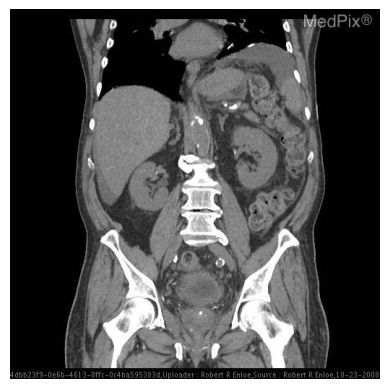

In [28]:
# Plotando a imagem a partir do GITHUB

def plot_image(image_name:str):
    # URL (raw) da imagem no GitHub
    url = 'https://raw.githubusercontent.com/CHILab1/MedPix-2.0/refs/heads/main/MedPix-2-0/images/'+ image_name +'.png'

    # Importando a imagem
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Mostrando a imagem
    plt.imshow(img)
    plt.axis('off')  # tira os eixos
    plt.show() 

plot_image(image_name="MPX1009_synpic46283")

Exemplo de imagem de MR

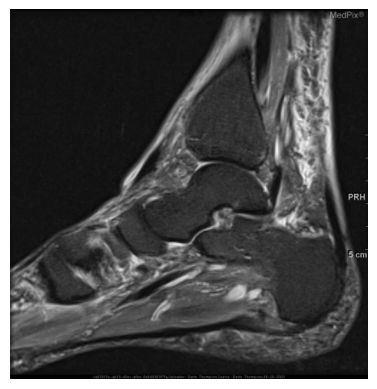

In [29]:
plot_image("MPX2586_synpic17310")

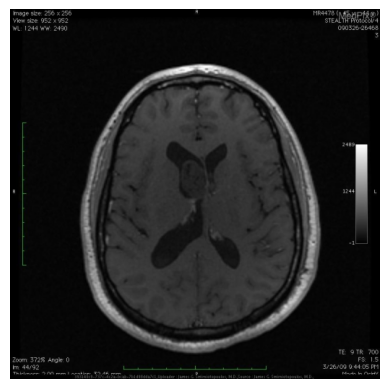

In [30]:
plot_image("MPX2607_synpic52590")

## Distribuicao das Imagens

Os autores mesmo buscaram construir o conjunto de dados de modo que ele fosse o mais balanceado possível entre as classes.

In [31]:
df.Type.value_counts(normalize=True)

Type
MR    0.573604
CT    0.426396
Name: proportion, dtype: float64

# **1 Desenvolvimento**

Como o objetivo do trabalho 01 é construir um classificador binário, usaremos apenas os dados do Documento Descriptions, referente às imagens. 

Usaremos os conjuntos de dados `train_1` e `train_2` para o treinamento, o conjunto `dev` para validação e o conjunto `test` para teste das predições.

Existem 1643 imagens no conjunto de treino sendo: 

* 810 imagens em `train_1`
* 843 imagens em `train_2`

## Organização das Imagens de Treino

In [32]:
DESCRIPTIONS_TRAIN_PATH = "./MedPix-2.0/splitted_dataset/descriptions_train.jsonl"

In [33]:
def read_train_data(path:str):
    
    with open(path, "r+") as f:
        lines = f.readlines()
    
        dados = []
        for linha in lines:
            registro = json.loads(linha)
            descricao = registro.pop("Description")
            registro.update(descricao)
            dados.append(registro)

    # Criando o DataFrame
    df = pd.DataFrame(dados) 

    return df

In [34]:
df_train = read_train_data(DESCRIPTIONS_TRAIN_PATH)

In [35]:
df_train.head()

Type     U_id                image          Location  \
0   CT  MPX1024  MPX1024_synpic40275  Chest, Pulmonary   
1   CT  MPX1024  MPX1024_synpic40277  Chest, Pulmonary   
2   CT  MPX1012  MPX1012_synpic22949     Genitourinary   
3   CT  MPX1012  MPX1012_synpic22950     Genitourinary   
4   CT  MPX1016  MPX1016_synpic34317  Chest, Pulmonary   

                 Location Category ACR Codes Age  \
0                           Thorax     -1.-1  60   
1                           Thorax     -1.-1  60   
2  Reproductive and Urinary System       8.2  14   
3  Reproductive and Urinary System       8.2  14   
4                           Thorax       6.3  43   

                                             Caption Figure Part  \
0  CT of the chest reveals an obstructing mass an...        None   
1  CT of the chest reveals an obstructing mass an...        None   
2                                             pelvis        None   
3                                             pelvis        None   
4  Contrast enhanced chest CT shows diffuse incre...          2a   

                Modality  Plane     Sex  
0       CT - noncontrast  Axial  female  
1       CT - noncontrast  Axial  female  
2  CT - GI & IV Contrast  Axial  female  
3  CT - GI & IV Contrast  Axial  female  
4     CT w/contrast (IV)  Axial  female

In [36]:
images = []

train_img_path = read_train_data(DESCRIPTIONS_TRAIN_PATH)['image'] 

for img_name in train_img_path:
    img_name = "./MedPix-2.0/images/" + img_name + ".png"
    images.append(img_name)

## Gerando o dataset com as imagens

In [37]:
df_train.query("image == 'MPX2594_synpic20735'")['Type'].item()

'MR'

In [38]:
train_img_list = []

for image in images:
    try:
        image_id = image.split("/")[3].split(".")[0]
        img_type = df_train.query("image == @image_id")["Type"].item()
        image_data = io.imread(image) 
        image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB) 

        train_img_dict = {
            "Image_ID": image_id,
            "Class": img_type,
            "Image": image_data
        }

        train_img_list.append(train_img_dict)

    except Exception as e:
        print("Warning:", image)
        print(e)


Visualizando as 30 primeiras imagens do dataset de treino.

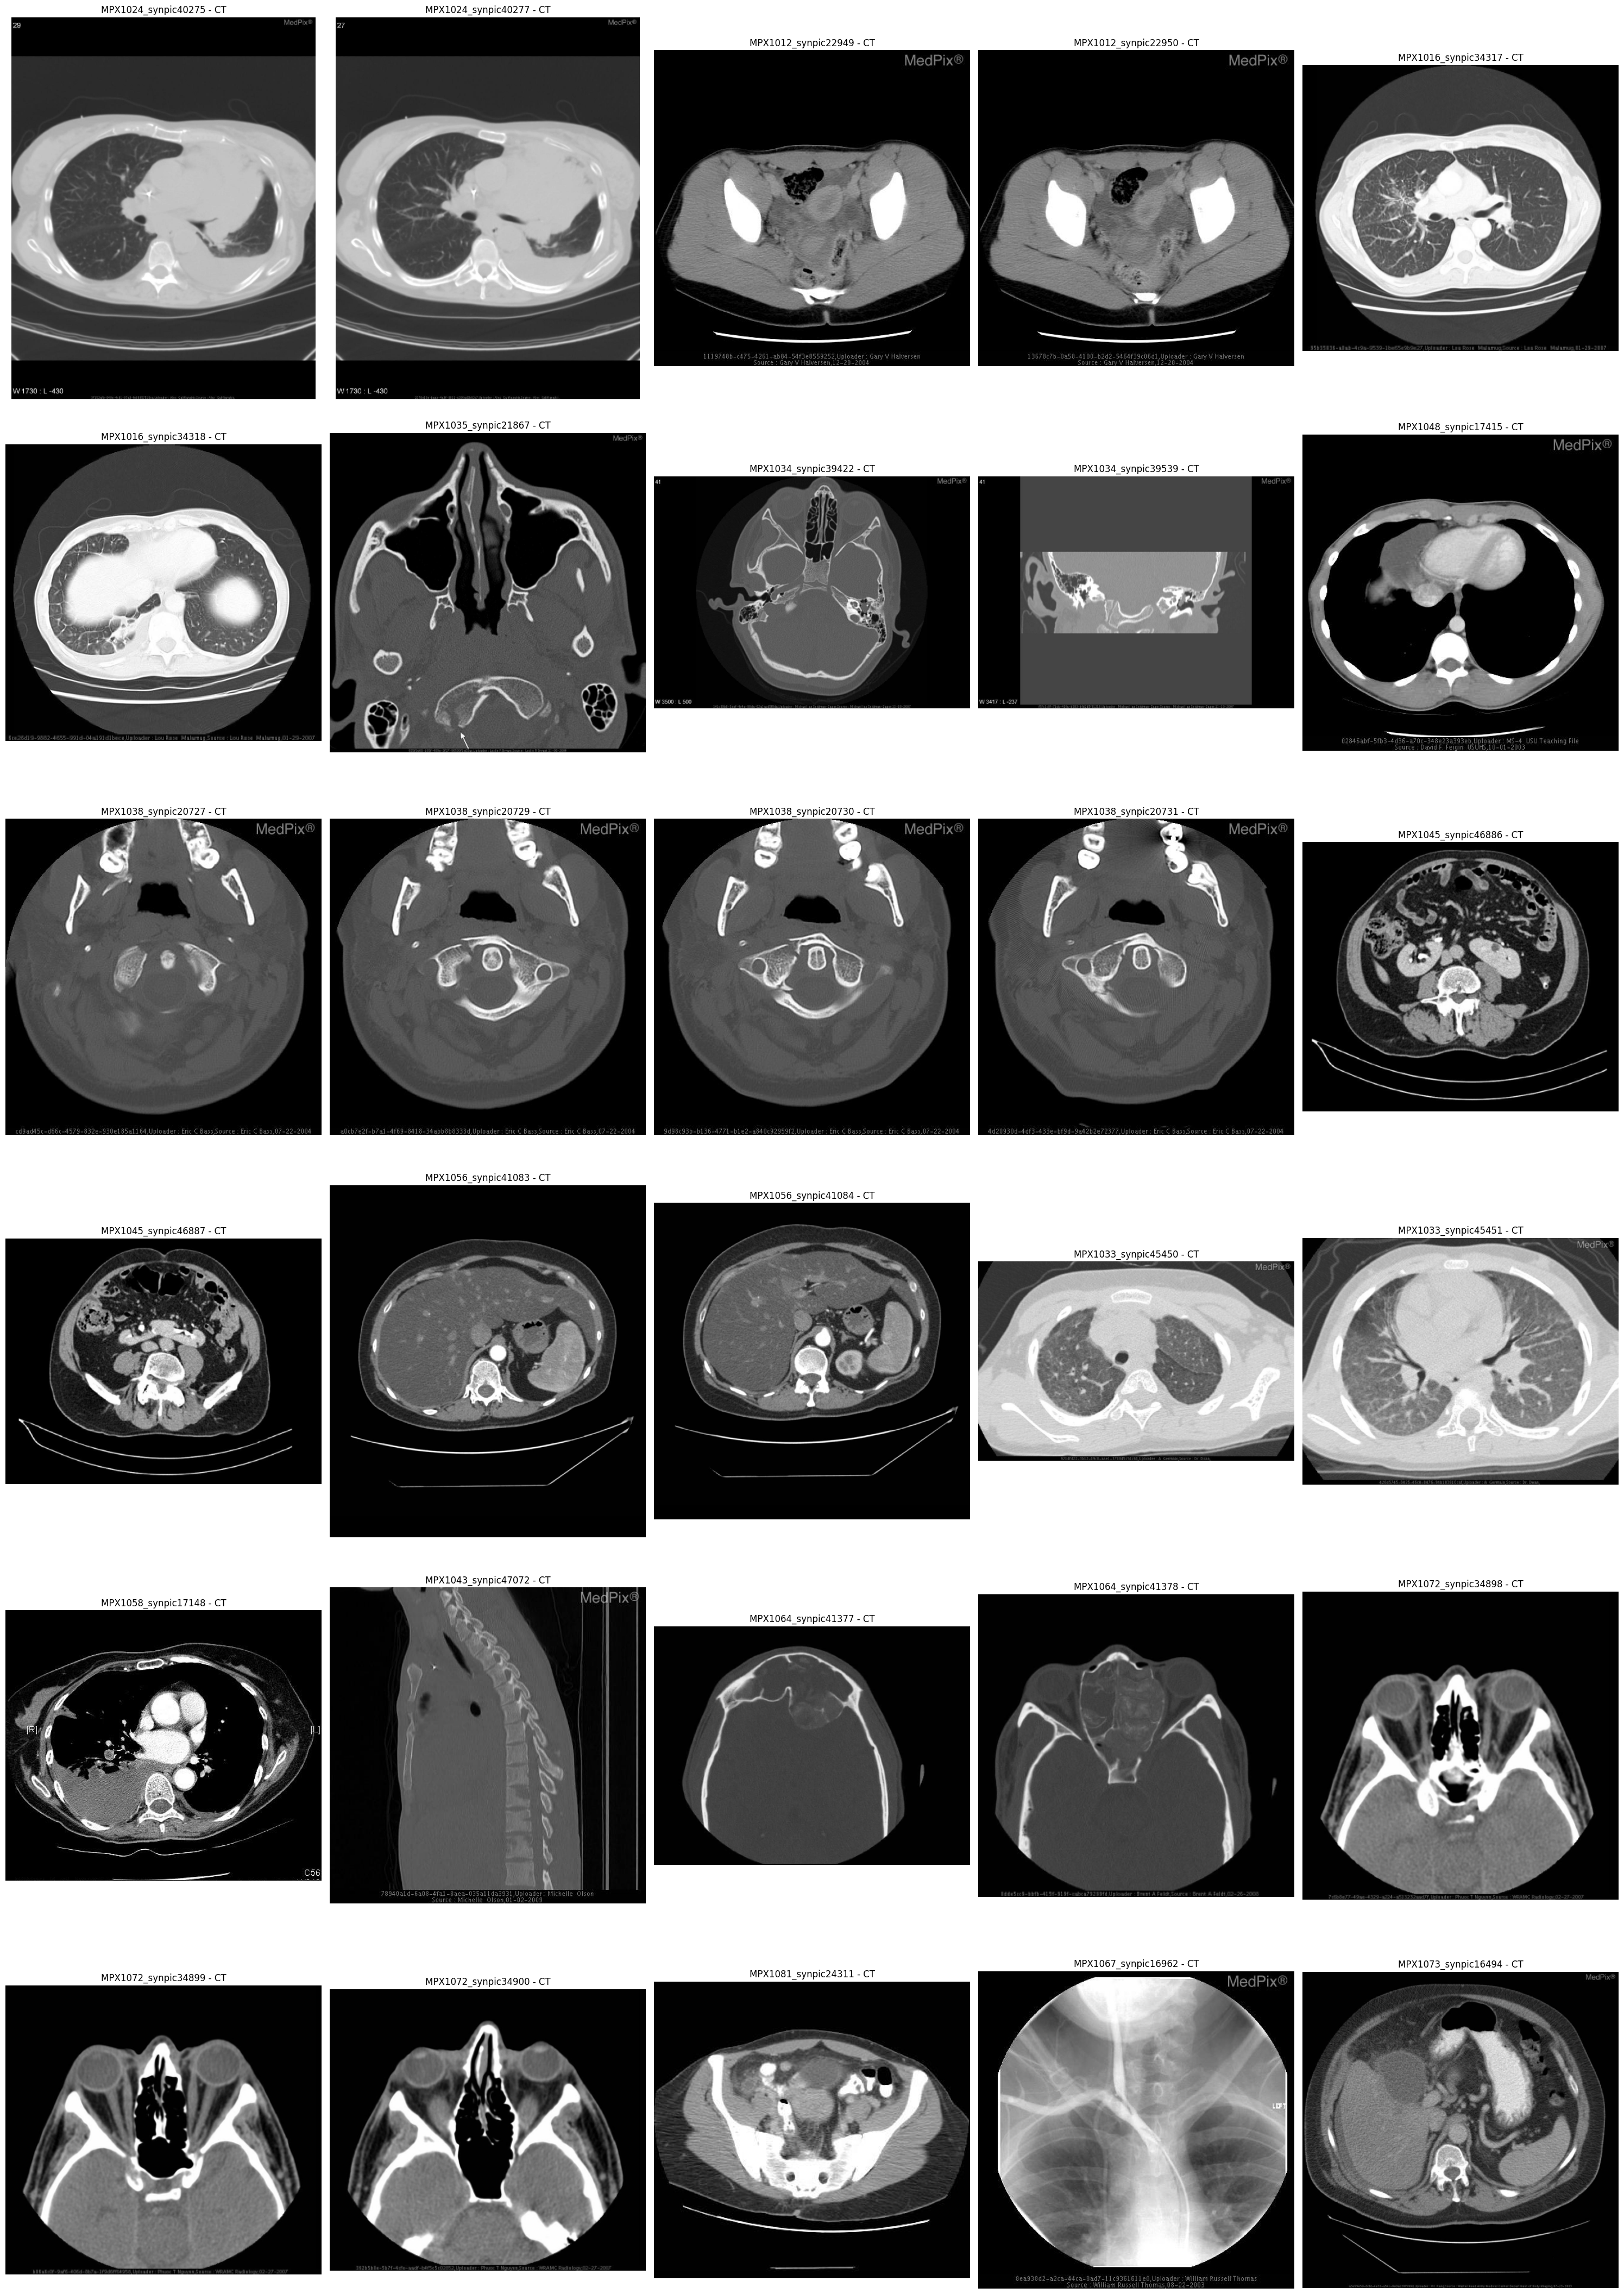

In [39]:
plt.figure(figsize=(30, 50)) 
columns = 5

for i, img_dict in enumerate(train_img_list[:30]):
    plt.subplot(int(len(train_img_list[:30]) / columns + 1), columns, i + 1)
    plt.imshow(cv2.cvtColor(img_dict["Image"], cv2.COLOR_RGB2BGR))
    plt.title(f'{img_dict["Image_ID"]} - {img_dict["Class"]}', fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Extraindo Descritores de Textura via Textura de Haralick

In [40]:
def extract_features(image):
        # calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(image)
        ht_mean = textures.mean(axis=0)
        return ht_mean

Visualizando texturas para uma Imagem

Altura 643
Largura 512
Canais 3


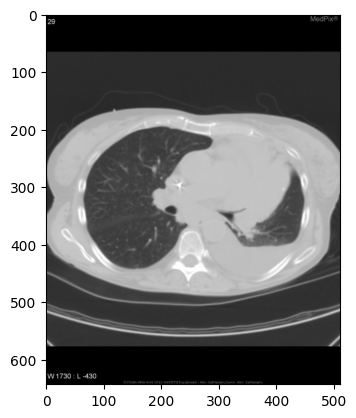

In [41]:
image = io.imread(images[0])

print("Altura", image.shape[0])
print("Largura", image.shape[1])
print("Canais", image.shape[2])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.show()

In [42]:
extract_features(image)

array([ 4.37744555e-02,  7.97788698e+01,  9.92812739e-01,  5.55016388e+03,
        6.70390503e-01,  1.77260081e+02,  2.21208767e+04,  6.52634919e+00,
        8.06095397e+00,  1.44216346e-03,  2.39959770e+00, -6.17052634e-01,
        9.99448352e-01])

### Caracteristicas das Texturas de Haralick

A função `extract_features` calcula 13 features com base nas texturas de Haralick, são elas:


1. **Momento Angular Segundo (ASM)**
Mede a uniformidade local dos níveis de cinza. Quando os pixels são muito semelhantes, o valor do ASM será grande.

2. **Contraste**
É uma medida da variação de intensidade ou dos níveis de cinza entre o pixel de referência e seus vizinhos. Um grande contraste reflete grandes diferenças de intensidade na matriz de coocorrência (GLCM).

3. **Correlação**
Mostra a dependência linear entre os valores de níveis de cinza na matriz de coocorrência.

4. **Soma dos quadrados: variância**
Atribui pesos relativamente altos aos elementos que diferem do valor médio da matriz. Mede a variância, associada à heterogeneidade.

5. M**omento de Diferença Inversa (IDM)**
Mede a homogeneidade local. Valores mais altos indicam menor variação local nos níveis de cinza.

6. **Média da Soma**
Mede a soma da média de todos os níveis de cinza.

7. **Variância da Soma**
Mede a heterogeneidade e está fortemente correlacionada com variáveis estatísticas de primeira ordem, como o desvio padrão. Aumenta quando os valores dos níveis de cinza se afastam da média.

8. **Entropia da Soma**
Mede a não-uniformidade ou a complexidade da textura na imagem.

9. **Entropia**
Mede a desordem de uma imagem e atinge seu valor máximo quando todos os elementos da matriz de probabilidade (P) são iguais.

10. **Variância da Diferença**
Definida como a variância de p(x−y), de maneira similar à variância da soma. Mede a variabilidade nas diferenças entre pares de pixels.

11. **Entropia da Diferença**
Mede a aleatoriedade ou falta de estrutura/ordem no contraste da imagem.

12. **Medida de Informação de Correlação 1**
Mede a correlação baseada em medidas de informação mútua entre variáveis, utilizando diferentes abordagens estatísticas.

13. **Medida de Informação de Correlação 2**
Uma segunda abordagem para medir correlação com base em informação mútua entre os níveis de cinza.

## Extraindo Descritores de Textura

In [43]:
from tqdm.notebook import tqdm 

X = [] 
y_true = [] 
counter = 0 
for image in tqdm(train_img_list):
    textures = extract_features(image["Image"])
    y_true.append(image["Class"])
    X.append(textures)
    counter += 1

  0%|          | 0/1653 [00:00<?, ?it/s]

In [48]:
X_textura = np.array(X)

In [55]:
label_map = {"CT":1, "MR":0}
label_reverse_map = {1:"CT", 0:"MR"}
y_true_encoded = [label_map[class_] for class_ in y_true]

## Classificando Usando Texturas

In [73]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X_textura, y_true_encoded, test_size=0.2, random_state=42) 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 

neigh = KNeighborsClassifier(n_neighbors=3, metric="cosine") 
neigh.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

### Predição Conjunto de Validação 

In [74]:
X_test = scaler.transform(X_test) 
y_pred = neigh.predict(X_test) 

# y_pred

### Métricas de Avaliação

In [75]:
from sklearn.metrics import classification_report 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       144
           1       0.93      0.91      0.92       187

    accuracy                           0.91       331
   macro avg       0.91      0.91      0.91       331
weighted avg       0.91      0.91      0.91       331

